In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

In [4]:
X, y = digits.data, digits.target

In [5]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [6]:
X.shape

(1797, 64)

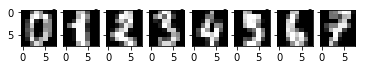

In [7]:
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')

In [8]:
from sklearn.model_selection import learning_curve 

In [9]:
from keras.models import Sequential 
from keras.layers import Dense 
from keras.wrappers.scikit_learn import KerasClassifier 
from keras.utils import to_categorical 
import keras.backend as K 
from keras.callbacks import EarlyStopping 

/home/qinritukou/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
K.clear_session()

model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [11]:
# store the initial random weihgts 
initial_weights = model.get_weights()

In [12]:
y_cat = to_categorical(y, 10)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)

In [15]:
train_sizes = (len(X_train) * np.linspace(0.1, 0.999, 4)).astype(int)
train_sizes

array([ 125,  502,  879, 1255])

In [16]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration reset the weights of the model 
    # to the initial random weights 
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac, verbose=0,
                 epochs=300, callbacks=[EarlyStopping(monitor='loss', patience=1)])
    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size:", train_size)

/home/qinritukou/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Done size: 125
Done size: 502
Done size: 879
Done size: 1255


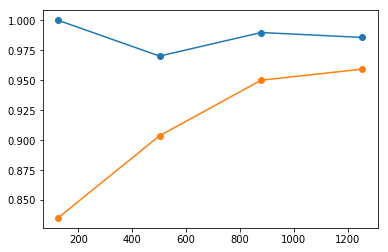

In [17]:
plt.plot(train_sizes, train_scores, 'o-', label='Training score')
plt.plot(train_sizes, test_scores, 'o-', label='Cross-validation score')

In [18]:
from keras.layers import BatchNormalization

In [19]:
def repeated_training(X_train,
                     y_train, 
                     X_test, 
                     y_test, 
                     units=512, 
                     activation='sigmoid',
                     optimizer='sgd',
                     do_bn=False,
                     epochs=10,
                     repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()
        
        model = Sequential() 
        
        # first fully connected layer 
        model.add(Dense(units, 
                       input_shape = X_train.shape[1:],
                       kernel_initializer='normal',
                       activation=activation))
        
        if do_bn:
            model.add(BatchNormalization())
            
        # secnd fully connected layer 
        model.add(Dense(units, kernel_initializer='normal',
                       activation=activation))    
        
        if do_bn:
            model.add(BatchNormalization())
            
        # third fully connected layer 
        model.add(Dense(units, kernel_initializer='normal',
                       activation=activation))
        
        if do_bn:
            model.add(BatchNormalization())
            
        # output layer 
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer, 
                     'categorical_crossentropy',
                     metrics=['accuracy'])
        
        h = model.fit(X_train, y_train, 
                     validation_data = (X_test, y_test),
                     epochs=epochs,
                     verbose=0)
        histories.append([h.history['acc'], h.history['val_acc']])
        print(repeat, end=' ')
    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print() 
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [20]:
mean_acc, std_acc, mean_acc_val, std_acc_val = repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

0 1 2 


In [21]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

0 1 2 


In [22]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

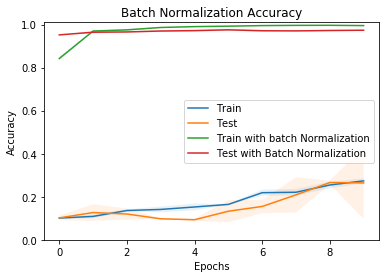

In [23]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title('Batch Normalization Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with batch Normalization', 'Test with Batch Normalization'])

<h1>Weight Regularization & Dropout</h1>

In [24]:
from keras.layers import Dropout 

In [26]:
model = Sequential() 
model.add(Dropout(0.2, input_shape=X_train.shape[1:]))
# first fully connected layer 
model.add(Dense(512, kernel_initializer='normal',
               kernel_regularizer='l2', activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile('sgd',
             'categorical_crossentropy',
             metrics=['accuracy'])

<h1>Data augmentation</h1>

In [28]:
from keras.preprocessing.image import ImageDataGenerator

In [29]:
generator = ImageDataGenerator(rescale=1./255,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rotation_range=20,
                              shear_range=0.3,
                              horizontal_flip=True)

In [30]:
train = generator.flow_from_directory('data/generator',
                                     target_size=(128, 128),
                                     batch_size=32, 
                                     class_mode='binary')

Found 1 images belonging to 1 classes.


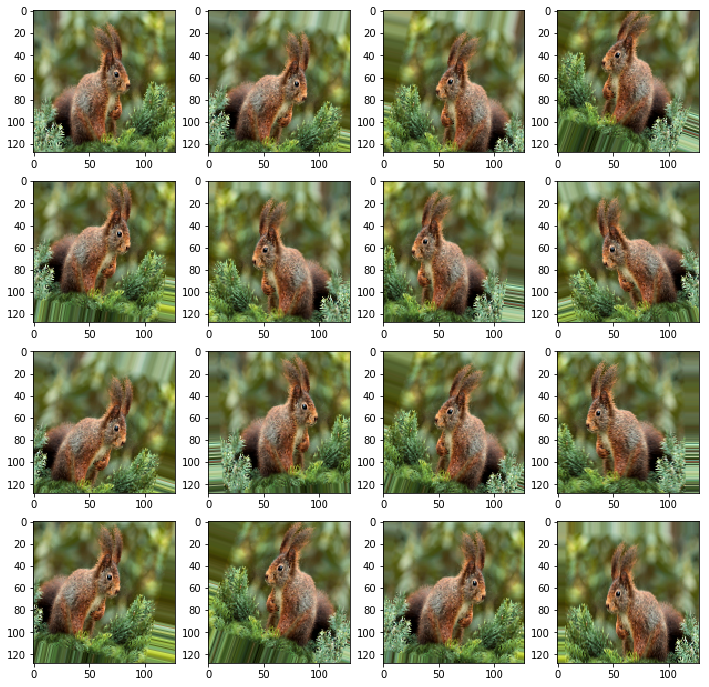

In [31]:
plt.figure(figsize=(12, 12))
for i in range(16):
    img, label = train.next()
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[0])